# Model Training

In [1]:
import os
os.chdir('/home/roobz/Jupyter/afib-detector/src/')

In [2]:
import matplotlib.pyplot as plt
import random
import pandas as pd
import numpy as np

# ML
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import optuna

# Local libraries
from mobilenetv2 import MobileNetV2
from models import Afib_CNN, Hsieh2020
from model import epoch_train, epoch_test, save_model
from dataset import AfibDataset, ExpandedAfibDataset

%load_ext autoreload
%autoreload 2

## Setup

In [3]:
#### data_folder = '../data/physionet/afdb/'
window_size = 2500
train_dataset, test_dataset = ExpandedAfibDataset.load_train_test_datasets(
    random_seed=42,
    fold=1
)
model_train_kwargs = {
    'train_size': len(train_dataset),
    'batch_size': 32,
}
model_test_kwargs = {
    'test_size': len(test_dataset),
    'test_batch_size': 1000
}
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# train_dataset, test_dataset = load_train_test_datasets(
#     window_size,
#     model_train_kwargs['train_size'],
#     model_test_kwargs['test_size'],
#     random_seed=42
# )

In [4]:
def train_model(
    model_class,
    model_args,
    epochs,
    lr=1,
    weight_decay=1e-5,
    gamma=1,
    outpath='../model.pt',
    train_dataset=train_dataset,
    test_dataset=test_dataset
):
    training_record = []
    try:
        model_args = pd.Series(model_args)
        model = model_class(**model_args).to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay) 
        print(optimizer)
#         scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
        scheduler = ReduceLROnPlateau(optimizer=optimizer, patience=3, min_lr=1e-07)

        print(f'Model size after convolutions: {model.fc1_size}')
        for epoch in range(1, epochs+1):
            
            print(f'EPOCH {epoch}:\tlr:{optimizer.param_groups[0]["lr"]: .3g}')
            print(f'Training...', end='')
            train_acc, train_loss = epoch_train(model, device, train_dataset, optimizer, epoch, print_progress='pct', **model_train_kwargs)
            acc, loss = epoch_test(model, device, test_dataset, **model_test_kwargs)
            scheduler.step(loss)
            print(f'\rTrain Accuracy: {train_acc: .1f}% \tTrain Loss: {train_loss: .4f}')
            print(f'Test Accuracy:  {acc: .1f}% \tTest Loss: {loss: .4f}')
            
            # checkpoint if better than minimum
            if training_record and loss <= (min([r[1] for r in training_record])* (1 + 1e-3)):
                save_model(model, outpath)
            
            # record training
            training_record.append((train_loss, loss, train_acc, acc))

        return model, training_record
    except KeyboardInterrupt:
        train_dataset.flush()
        test_dataset.flush()
        print('\n-----Force Stop-----')
        return model, training_record
    
def record_plot(record, figsize=None):
    fig, axes = plt.subplots(2, figsize=figsize)
    record = pd.DataFrame(record, columns=['Train Loss', 'Test Loss', 'Train Acc', 'Test Acc'])
    record = record.set_index(record.index + 1)
    loss = record[['Train Loss', 'Test Loss']]
    acc = record[['Train Acc', 'Test Acc']]
    loss.plot(xlabel='Epoch', ylabel='Loss', legend=True, ax=axes[0])
    acc.plot(xlabel='Epoch', ylabel='Accuracy', legend=True, ax=axes[1])

## Training Custom Model

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 8e-05
    weight_decay: 1e-05
)
Model size after convolutions: 38912
EPOCH 1:	lr: 8e-05
Train Accuracy:  89.7% 	Train Loss:  0.2417
Test Accuracy:   96.8% 	Test Loss:  0.1040
EPOCH 2:	lr: 8e-05
Train Accuracy:  97.9% 	Train Loss:  0.0699
Test Accuracy:   97.8% 	Test Loss:  0.0703
EPOCH 3:	lr: 8e-05
Train Accuracy:  98.6% 	Train Loss:  0.0483
Test Accuracy:   97.8% 	Test Loss:  0.0645
EPOCH 4:	lr: 8e-05
Train Accuracy:  98.9% 	Train Loss:  0.0355
Test Accuracy:   98.4% 	Test Loss:  0.0505
EPOCH 5:	lr: 8e-05
Train Accuracy:  99.2% 	Train Loss:  0.0284
Test Accuracy:   98.5% 	Test Loss:  0.0526
EPOCH 6:	lr: 8e-05
Train Accuracy:  99.3% 	Train Loss:  0.0247
Test Accuracy:   98.8% 	Test Loss:  0.0436
EPOCH 7:	lr: 8e-05
Train Accuracy:  99.3% 	Train Loss:  0.0225
Test Accuracy:   98.6% 	Test Loss:  0.0490
EPOCH 8:	lr: 8e-05
Train Accuracy:  99.4% 	Train Loss:  0.0198
Test Accuracy:   98.2% 	Test Loss: 

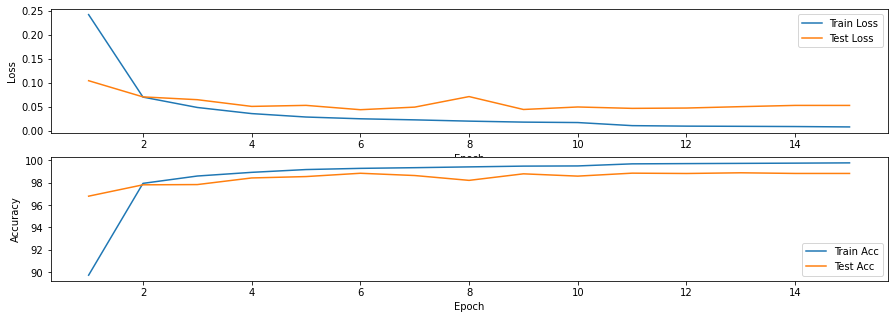

In [8]:
train_dataset, test_dataset = ExpandedAfibDataset.load_train_test_datasets(
    random_seed=42,
    fold=1
)

model, training_record = train_model(
    Afib_CNN,
    {
        'channels': 2,
        'repeat_layers': 0
    },
    epochs=15,
    lr=8e-5,
    weight_decay=1e-5,
    gamma=1,
    outpath='../models/Custom/custom fold1.pt'
)

print(f'Min validation loss: {min([r[1] for r in training_record]): .3f}')
record_plot(training_record, figsize=(15, 5))

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 8e-05
    weight_decay: 1e-05
)
Model size after convolutions: 38912
EPOCH 1:	lr: 8e-05
Train Accuracy:  89.9% 	Train Loss:  0.2498
Test Accuracy:   96.1% 	Test Loss:  0.1168
EPOCH 2:	lr: 8e-05
Train Accuracy:  98.0% 	Train Loss:  0.0695
Test Accuracy:   98.3% 	Test Loss:  0.0627
EPOCH 3:	lr: 8e-05
Train Accuracy:  98.7% 	Train Loss:  0.0433
Test Accuracy:   98.7% 	Test Loss:  0.0496
EPOCH 4:	lr: 8e-05
Train Accuracy:  99.0% 	Train Loss:  0.0326
Test Accuracy:   98.8% 	Test Loss:  0.0451
EPOCH 5:	lr: 8e-05
Train Accuracy:  99.3% 	Train Loss:  0.0255
Test Accuracy:   98.7% 	Test Loss:  0.0521
EPOCH 6:	lr: 8e-05
Train Accuracy:  99.3% 	Train Loss:  0.0229
Test Accuracy:   98.0% 	Test Loss:  0.0743
EPOCH 7:	lr: 8e-05
Train Accuracy:  99.4% 	Train Loss:  0.0210
Test Accuracy:   98.6% 	Test Loss:  0.0533
EPOCH 8:	lr: 8e-05
Train Accuracy:  99.5% 	Train Loss:  0.0185
Test Accuracy:   98.9% 	Test Loss: 

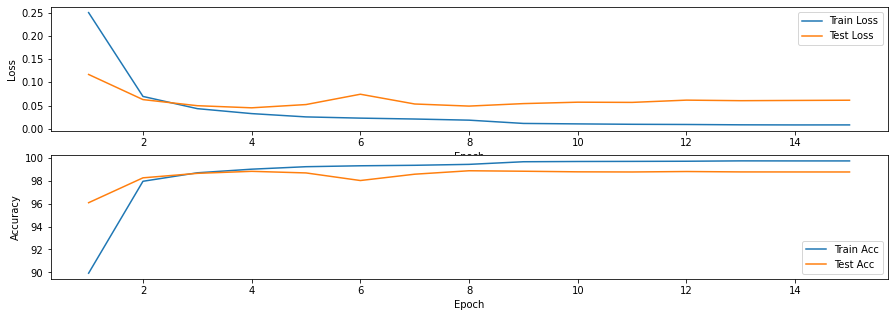

In [9]:
train_dataset, test_dataset = ExpandedAfibDataset.load_train_test_datasets(
    random_seed=42,
    fold=2
)

model, training_record = train_model(
    Afib_CNN,
    {
        'channels': 2,
        'repeat_layers': 0
    },
    epochs=15,
    lr=8e-5,
    weight_decay=1e-5,
    gamma=1,
    outpath='../models/Custom/custom fold2.pt'
)

print(f'Min validation loss: {min([r[1] for r in training_record]): .3f}')
record_plot(training_record, figsize=(15, 5))

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 8e-05
    weight_decay: 1e-05
)
Model size after convolutions: 38912
EPOCH 1:	lr: 8e-05
Train Accuracy:  87.3% 	Train Loss:  0.2846
Test Accuracy:   94.7% 	Test Loss:  0.1558
EPOCH 2:	lr: 8e-05
Train Accuracy:  97.5% 	Train Loss:  0.0799
Test Accuracy:   98.1% 	Test Loss:  0.0738
EPOCH 3:	lr: 8e-05
Train Accuracy:  98.6% 	Train Loss:  0.0492
Test Accuracy:   98.4% 	Test Loss:  0.0597
EPOCH 4:	lr: 8e-05
Train Accuracy:  98.9% 	Train Loss:  0.0371
Test Accuracy:   98.6% 	Test Loss:  0.0471
EPOCH 5:	lr: 8e-05
Train Accuracy:  99.2% 	Train Loss:  0.0304
Test Accuracy:   98.8% 	Test Loss:  0.0442
EPOCH 6:	lr: 8e-05
Train Accuracy:  99.3% 	Train Loss:  0.0257
Test Accuracy:   98.8% 	Test Loss:  0.0483
EPOCH 7:	lr: 8e-05
Train Accuracy:  99.4% 	Train Loss:  0.0227
Test Accuracy:   98.8% 	Test Loss:  0.0512
EPOCH 8:	lr: 8e-05
Train Accuracy:  99.5% 	Train Loss:  0.0198
Test Accuracy:   98.9% 	Test Loss: 

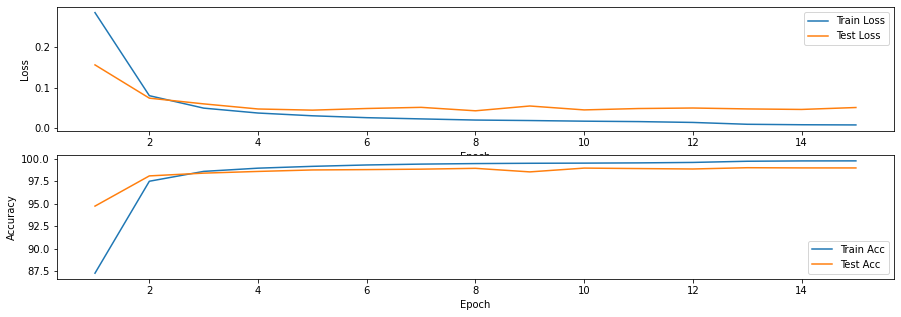

In [10]:
train_dataset, test_dataset = ExpandedAfibDataset.load_train_test_datasets(
    random_seed=42,
    fold=3
)

model, training_record = train_model(
    Afib_CNN,
    {
        'channels': 2,
        'repeat_layers': 0
    },
    epochs=15,
    lr=8e-5,
    weight_decay=1e-5,
    gamma=1,
    outpath='../models/Custom/custom fold3.pt'
)

print(f'Min validation loss: {min([r[1] for r in training_record]): .3f}')
record_plot(training_record, figsize=(15, 5))

## Training Hsieh Model

In [7]:
train_dataset, test_dataset = ExpandedAfibDataset.load_train_test_datasets(
    random_seed=42,
    fold=1
)

In [8]:
model, training_record = train_model(
    Hsieh2020,
    {
        'channels': 2,
    },
    epochs=15,
    lr=1e-3,
    weight_decay=5e-5,
    outpath='../models/Hsieh2020 fold1.pt',
    train_dataset=train_dataset,
    test_dataset=test_dataset
)

/home/roobz/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /tmp/pip-req-build-1_ic8ial/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 5e-05
)
Model size after convolutions: 2560
EPOCH 1:	lr: 0.001
Train Accuracy:  97.3% 	Train Loss:  0.0737
Test Accuracy:   99.0% 	Test Loss:  0.0467
EPOCH 2:	lr: 0.001
Train Accuracy:  99.2% 	Train Loss:  0.0348
Test Accuracy:   99.3% 	Test Loss:  0.0259
EPOCH 3:	lr: 0.001
Train Accuracy:  99.3% 	Train Loss:  0.0276
Test Accuracy:   99.0% 	Test Loss:  0.0416
EPOCH 4:	lr: 0.001
Train Accuracy:  99.3% 	Train Loss:  0.0272
Test Accuracy:   99.1% 	Test Loss:  0.0331
EPOCH 5:	lr: 0.001
Train Accuracy:  99.3% 	Train Loss:  0.0261
Test Accuracy:   99.0% 	Test Loss:  0.0333
EPOCH 6:	lr: 0.001
Train Accuracy:  99.3% 	Train Loss:  0.0258
Test Accuracy:   99.0% 	Test Loss:  0.0729
EPOCH 7:	lr: 0.0001
Train Accuracy:  99.6% 	Train Loss:  0.0156
Test Accuracy:   99.1% 	Test Loss:  0.0312
EPOCH 8:	lr: 0.0001
Train Accuracy:  99.6% 	Train Loss:  0.0129
Test Accuracy:   99.1% 	Test Loss:

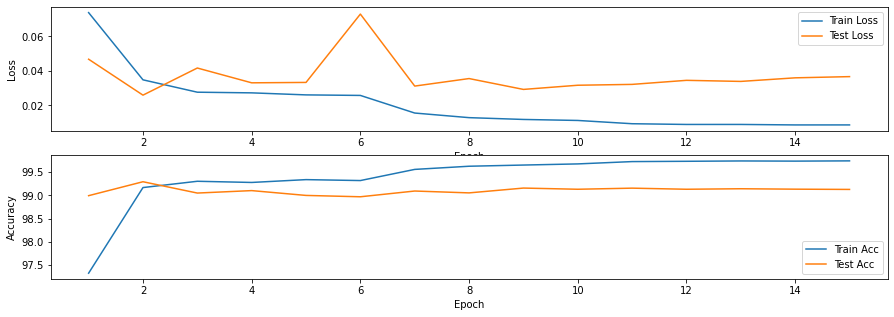

In [9]:
record_plot(training_record, figsize=(15, 5))

In [10]:
train_dataset, test_dataset = ExpandedAfibDataset.load_train_test_datasets(
    random_seed=42,
    fold=2
)

In [11]:
model, training_record = train_model(
    Hsieh2020,
    {
        'channels': 2,
    },
    epochs=15,
    lr=1e-3,
    weight_decay=5e-5,
    outpath='../models/Hsieh2020 fold2.pt',
    train_dataset=train_dataset,
    test_dataset=test_dataset
)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 5e-05
)
Model size after convolutions: 2560
EPOCH 1:	lr: 0.001
Train Accuracy:  80.1% 	Train Loss:  0.2920
Test Accuracy:   98.6% 	Test Loss:  0.0483
EPOCH 2:	lr: 0.001
Train Accuracy:  98.8% 	Train Loss:  0.0459
Test Accuracy:   99.1% 	Test Loss:  0.0339
EPOCH 3:	lr: 0.001
Train Accuracy:  99.1% 	Train Loss:  0.0352
Test Accuracy:   98.5% 	Test Loss:  0.0526
EPOCH 4:	lr: 0.001
Train Accuracy:  99.1% 	Train Loss:  0.0319
Test Accuracy:   99.3% 	Test Loss:  0.0330
EPOCH 5:	lr: 0.001
Train Accuracy:  99.2% 	Train Loss:  0.0301
Test Accuracy:   99.2% 	Test Loss:  0.0315
EPOCH 6:	lr: 0.001
Train Accuracy:  99.3% 	Train Loss:  0.0275
Test Accuracy:   98.5% 	Test Loss:  0.0405
EPOCH 7:	lr: 0.001
Train Accuracy:  99.3% 	Train Loss:  0.0271
Test Accuracy:   99.5% 	Test Loss:  0.0231
EPOCH 8:	lr: 0.001
Train Accuracy:  99.3% 	Train Loss:  0.0261
Test Accuracy:   99.4% 	Test Loss:  

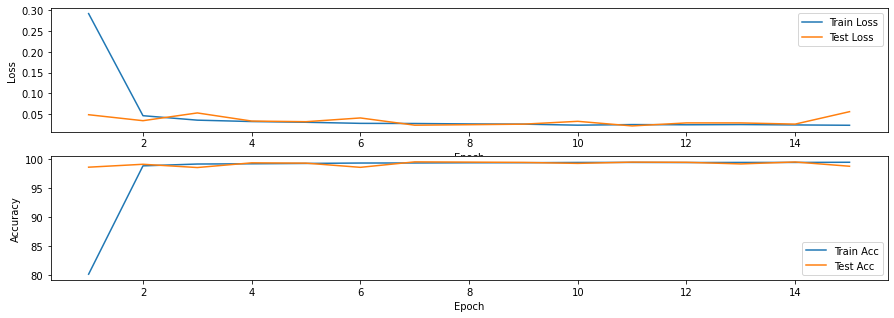

In [12]:
record_plot(training_record, figsize=(15, 5))

In [13]:
train_dataset, test_dataset = ExpandedAfibDataset.load_train_test_datasets(
    random_seed=42,
    fold=3
)

In [14]:
model, training_record = train_model(
    Hsieh2020,
    {
        'channels': 2,
    },
    epochs=15,
    lr=1e-3,
    weight_decay=5e-5,
    outpath='../models/Hsieh2020 fold3.pt',
    train_dataset=train_dataset,
    test_dataset=test_dataset
)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 5e-05
)
Model size after convolutions: 2560
EPOCH 1:	lr: 0.001
Train Accuracy:  97.1% 	Train Loss:  0.0769
Test Accuracy:   98.3% 	Test Loss:  0.0844
EPOCH 2:	lr: 0.001
Train Accuracy:  99.2% 	Train Loss:  0.0321
Test Accuracy:   98.5% 	Test Loss:  0.0920
EPOCH 3:	lr: 0.001
Train Accuracy:  99.3% 	Train Loss:  0.0284
Test Accuracy:   98.3% 	Test Loss:  0.0552
EPOCH 4:	lr: 0.001
Train Accuracy:  99.3% 	Train Loss:  0.0278
Test Accuracy:   98.7% 	Test Loss:  0.1154
EPOCH 5:	lr: 0.001
Train Accuracy:  99.3% 	Train Loss:  0.0246
Test Accuracy:   98.7% 	Test Loss:  0.0768
EPOCH 6:	lr: 0.001
Train Accuracy:  99.3% 	Train Loss:  0.0256
Test Accuracy:   98.5% 	Test Loss:  0.0817
EPOCH 7:	lr: 0.001
Train Accuracy:  99.4% 	Train Loss:  0.0235
Test Accuracy:   98.3% 	Test Loss:  0.0663
EPOCH 8:	lr: 0.0001
Train Accuracy:  99.5% 	Train Loss:  0.0148
Test Accuracy:   98.7% 	Test Loss: 

In [73]:
 def train_1d_mobilenet(epochs, outpath='../model.pt'):
    training_record = []
    try:
#         model_args = pd.Series(model_args)
        model = MobileNetV2(num_classes=2).to(device)
        optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5) 
        print(optimizer)
        scheduler = ReduceLROnPlateau(optimizer=optimizer, patience=3, min_lr=1e-07)

        for epoch in range(1, epochs+1):
            
            print(f'EPOCH {epoch}:\tlr:{optimizer.param_groups[0]["lr"]: .3g}')
            print(f'Training...', end='')
            train_acc, train_loss = epoch_train(model, device, train_dataset, optimizer, epoch, print_progress='pct', **model_train_kwargs)
            acc, loss = epoch_test(model, device, test_dataset, **model_test_kwargs)
            scheduler.step(loss)
            print(f'\rTrain Accuracy: {train_acc: .1f}% \tTrain Loss: {train_loss: .4f}')
            print(f'Test Accuracy:  {acc: .1f}% \tTest Loss: {loss: .4f}')
            
            # checkpoint if better than minimum
            if training_record and loss <= (min([r[1] for r in training_record])* (1 + 1e-3)):
                save_model(model, outpath)
            
            # record training
            training_record.append((train_loss, loss, train_acc, acc))
        return model, training_record
    except KeyboardInterrupt:
        train_dataset.flush()
        test_dataset.flush()
        print('\n-----Force Stop-----')
        return model, training_record

In [74]:
model, training_record = train_1d_mobilenet(30)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0003
    weight_decay: 1e-05
)
EPOCH 1:	lr: 0.0003
Train Accuracy:  97.7% 	Train Loss:  0.0667
Test Accuracy:   98.3% 	Test Loss:  0.0660
EPOCH 2:	lr: 0.0003
Train Accuracy:  99.2% 	Train Loss:  0.0267
Test Accuracy:   98.4% 	Test Loss:  0.0502
EPOCH 3:	lr: 0.0003
Train Accuracy:  99.4% 	Train Loss:  0.0216
Test Accuracy:   98.6% 	Test Loss:  0.0381
EPOCH 4:	lr: 0.0003
Train Accuracy:  99.4% 	Train Loss:  0.0187
Test Accuracy:   98.6% 	Test Loss:  0.0351
EPOCH 5:	lr: 0.0003
Train Accuracy:  99.5% 	Train Loss:  0.0162
Test Accuracy:   98.7% 	Test Loss:  0.0382
EPOCH 6:	lr: 0.0003
Train Accuracy:  99.5% 	Train Loss:  0.0158
Test Accuracy:   98.7% 	Test Loss:  0.0354
EPOCH 7:	lr: 0.0003
Train Accuracy:  99.6% 	Train Loss:  0.0144
Test Accuracy:   98.5% 	Test Loss:  0.0334
EPOCH 8:	lr: 0.0003
Train Accuracy:  99.6% 	Train Loss:  0.0133
Test Accuracy:   98.6% 	Test Loss:  0.0365
EPOCH 9:	lr: 0.0003


In [75]:
min([r[1] for r in training_record])

0.033374416305254506

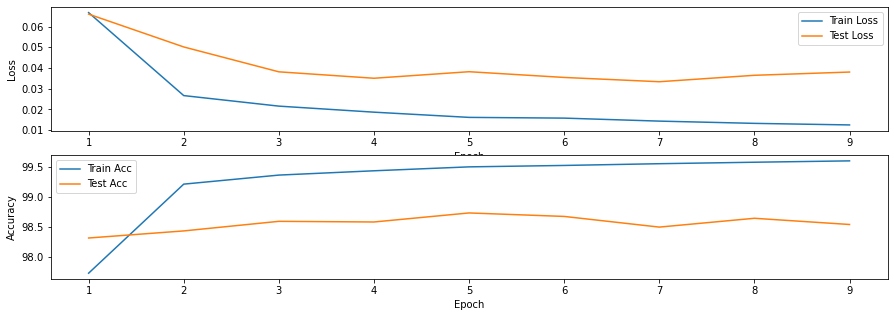

In [76]:
record_plot(training_record, figsize=(15, 5))